In [92]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict

In [93]:
# Load data
train_df = pd.read_csv('24_train_3.csv')
test_df = pd.read_csv('news-test-1.csv')

In [94]:
# 1 Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.7,
    ngram_range=(1, 2),
    stop_words='english'
)

In [95]:
# 1 Preprocess training data
train_val_X = vectorizer.fit_transform(train_df['Text'])  #the long article text
train_val_y = train_df['Category']                        #the correct answer

print(train_val_X.shape)
print(train_val_y.shape)

(1000, 5000)
(1000,)


In [96]:
# 1 Preprocess test data
test_X = vectorizer.transform(test_df['Text'])
print(test_X.shape)

(680, 5000)


In [97]:
# 2 Split data into training and validation sets (80% training, 20% validation)
train_val_X_split, val_X, train_val_y_split, val_y = train_test_split(
    train_val_X, train_val_y, test_size=0.2, random_state=42
)

print(train_val_X_split.shape)
print(val_X.shape)
print(train_val_y_split.shape)
print(val_y.shape)

(800, 5000)
(200, 5000)
(800,)
(200,)


In [98]:
# 2.1 Initialize models with different criteria
criteria = ["gini", "entropy"]
train_accuracies = []
val_accuracies = []

for criterion in criteria:
    # Train Decision Tree
    model = DecisionTreeClassifier(criterion=criterion, random_state=42)
    model.fit(train_val_X_split, train_val_y_split)

    # Compute training accuracy
    train_acc = accuracy_score(train_val_y_split, model.predict(train_val_X_split))
    train_accuracies.append(train_acc)

    # Compute validation accuracy
    val_acc = accuracy_score(val_y, model.predict(val_X))
    val_accuracies.append(val_acc)

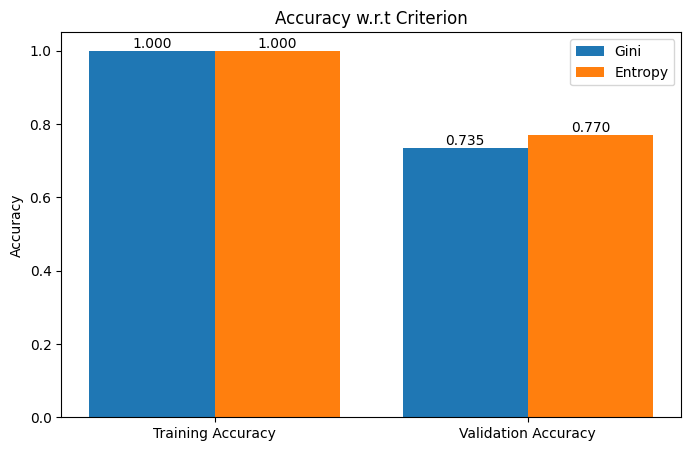

In [99]:
# 2.1 Plot the results
plt.figure(figsize=(8, 5))
bar_width = 0.4
indices = np.arange(2)

bars1 = plt.bar(indices, [train_accuracies[0], val_accuracies[0]], bar_width, label="Gini")
bars2 = plt.bar(indices + bar_width, [train_accuracies[1], val_accuracies[1]], bar_width, label="Entropy")

# Add accuracy numbers on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.3f}", ha='center', va='bottom')

plt.title("Accuracy w.r.t Criterion")
plt.ylabel("Accuracy")

plt.xticks(indices + bar_width / 2, ["Training Accuracy", "Validation Accuracy"])
plt.legend()
plt.show()

In [100]:
# 2.2.1 Report the average training and validation accuracy, and their standard deviation for different parameter values (organize the results in a table).

# Initialize results list
min_results = []
depths = [10, 25, 50, 75, 100, 125, 150, 200]   # min_samples_leaf

# Perform 5-fold cross-validation for each depth
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for depth in depths:
    train_acc = []
    val_acc = []

    for train_index, val_index in kf.split(train_val_X):
        train_X, val_X = train_val_X[train_index, :], train_val_X[val_index, :]
        train_y, val_y = train_val_y[train_index], train_val_y[val_index]

        dtc = tree.DecisionTreeClassifier(max_depth=depth)
        dtc.fit(train_X, train_y)

        train_acc.append(dtc.score(train_X, train_y))
        val_acc.append(dtc.score(val_X, val_y))

    # Compute mean & std deviation
    mean_train_acc = np.mean(train_acc)
    std_train_acc = np.std(train_acc)
    mean_val_acc = np.mean(val_acc)
    std_val_acc = np.std(val_acc)

    # Store results in a table
    min_results.append({
        "min_samples_leaf": depth,
        "mean_training_accuracy": round(mean_train_acc, 4),
        "std_training_accuracy": round(std_train_acc, 4),
        "mean_validation_accuracy": round(mean_val_acc, 4),
        "std_validation_accuracy": round(std_val_acc, 4),
    })

# Convert results to DataFrame
min_results_df = pd.DataFrame(min_results)

# Display table
min_results_df

,min_samples_leaf,mean_training_accuracy,std_training_accuracy,mean_validation_accuracy,std_validation_accuracy
0,10,0.8098,0.0210,0.669,0.0338
1,25,0.9835,0.0138,0.766,0.0146
2,50,1.0000,0.0000,0.753,0.0204
3,75,1.0000,0.0000,0.768,0.0129
4,100,1.0000,0.0000,0.773,0.0196
5,125,1.0000,0.0000,0.779,0.0315
6,150,1.0000,0.0000,0.769,0.0235
7,200,1.0000,0.0000,0.763,0.0144


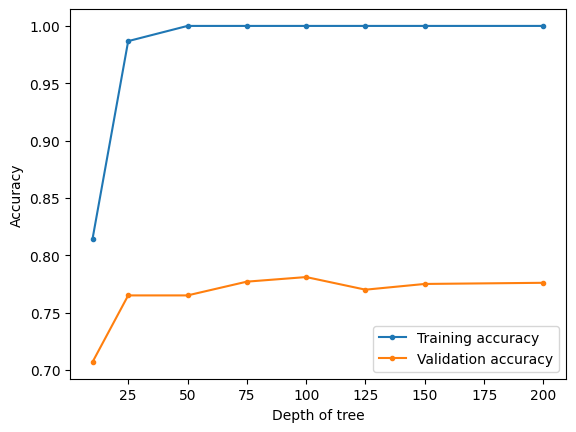

In [101]:
# 2.2.2 Draw a line figure showing the training and validation result, x-axis should be the parameter values, y-axis should be the training and cvalidation accuracy.
# from sample code Part 4: Decision Tree Parameter Tuning via Cross Validation
def dtc_parameter_tune(train_val_X, train_val_y):
    train_acc_all = []
    val_acc_all = []

    kf = KFold(n_splits = 5)
    for depth in depths:
        train_acc = []
        val_acc = []
        # print("========= depth:", depth)
        for train_index, val_index in kf.split(train_val_X):
            ##########################
            train_X = train_val_X[train_index,:]
            val_X = train_val_X[val_index,:]

            train_y = train_val_y[train_index]
            val_y = train_val_y[val_index]

            dtc = tree.DecisionTreeClassifier(max_depth=depth)
            dtc.fit(train_X, train_y)
            train_acc.append(dtc.score(train_X, train_y))
            val_acc.append(dtc.score(val_X, val_y))
            # print("========= val_index:", val_index)
            ##########################

        avg_train_acc = sum(train_acc) / len(train_acc)
        avg_val_acc = sum(val_acc) / len(val_acc)
        # print("Depth: ", depth)
        # print("Training accuracy: ", avg_train_acc * 100, "%")
        # print("Validation accuracy: ", avg_val_acc * 100, "%")

        train_acc_all.append(avg_train_acc)
        val_acc_all.append(avg_val_acc)

    return depths, train_acc_all, val_acc_all

depths, train_acc_all, val_acc_all = dtc_parameter_tune(train_val_X, train_val_y)

# plot training/validation curves
plt.plot(depths, train_acc_all, marker='.', label="Training accuracy")
plt.plot(depths, val_acc_all, marker='.', label="Validation accuracy")
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.legend()

In [102]:
# 2.3 Evaluate the decision tree using 5-fold cross-validation w.r.t max_features
# 2.3.1 table
# Define different max_features values to test
max_features_values = [None, "sqrt", "log2", 5, 10]  # Testing various options

# Initialize table to store results
max_results = []

# 5-Fold Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for max_features in max_features_values:
    train_acc = []
    val_acc = []

    for train_index, val_index in kf.split(train_val_X):
        train_X, val_X = train_val_X[train_index, :], train_val_X[val_index, :]
        train_y, val_y = train_val_y[train_index], train_val_y[val_index]

        # Train Decision Tree with different max_features values
        dtc = tree.DecisionTreeClassifier(max_features=max_features, random_state=42)
        dtc.fit(train_X, train_y)

        train_acc.append(dtc.score(train_X, train_y))
        val_acc.append(dtc.score(val_X, val_y))

    # Compute mean & std deviation
    mean_train_acc = np.mean(train_acc)
    std_train_acc = np.std(train_acc)
    mean_val_acc = np.mean(val_acc)
    std_val_acc = np.std(val_acc)

    # Store results in a table
    max_results.append({
        "max_features": str(max_features),
        "mean_training_accuracy": round(mean_train_acc, 4),
        "std_training_accuracy": round(std_train_acc, 4),
        "mean_validation_accuracy": round(mean_val_acc, 4),
        "std_validation_accuracy": round(std_val_acc, 4),
    })

# Convert results to DataFrame
max_results_df = pd.DataFrame(max_results)

# Display table
max_results_df

,max_features,mean_training_accuracy,std_training_accuracy,mean_validation_accuracy,std_validation_accuracy
0,None,1.0,0.0,0.769,0.0282
1,sqrt,1.0,0.0,0.648,0.0194
2,log2,1.0,0.0,0.656,0.0372
3,5,1.0,0.0,0.584,0.0421
4,10,1.0,0.0,0.610,0.0130


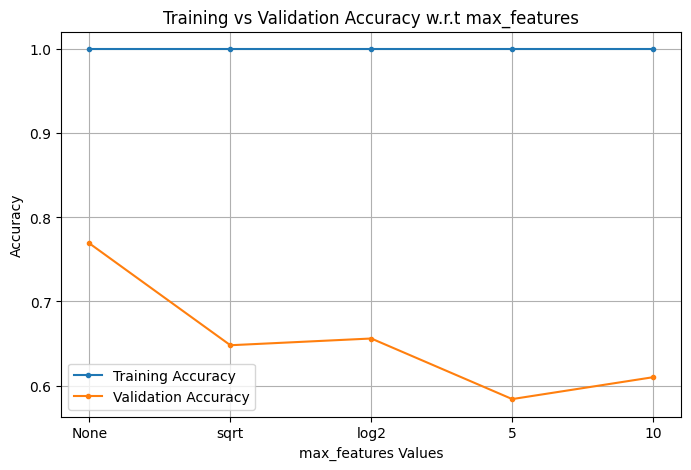

In [103]:
#2.3.2 line figure

# Extract values for plotting
max_features_labels = [str(f) for f in max_features_values]  # Convert to string for better labeling

plt.figure(figsize=(8, 5))

# Plot training and validation accuracy
plt.plot(max_features_labels, max_results_df["mean_training_accuracy"], marker='.', label="Training Accuracy")
plt.plot(max_features_labels, max_results_df["mean_validation_accuracy"], marker='.', label="Validation Accuracy")

# Labels and Title
plt.xlabel("max_features Values")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy w.r.t max_features")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

3.1 Describe your parameter setting

1. n_splits: Defines the number of folds in cross-validation (default = 5)

2. random_state: Ensures reproducibility (any fixed integer works)

We use n_splits=5 for 5-fold cross-validation and set random_state=42 for reproducibility.

In [104]:
# 3.2 Use 5-fold cross-validation to evaluate the performance w.r.t. the number of trees (n_estimators)
# 3.2.1 table

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define different values for n_estimators (number of trees)
n_estimators_values = [10, 50, 100, 200, 300]

# Store results in a list
randforest_n_estimators_results = []

# Loop through different numbers of trees
for n_trees in n_estimators_values:
    train_acc = []
    val_acc = []

    # Perform 5-fold cross-validation
    for train_index, val_index in kf.split(train_val_X):
        train_X, val_X = train_val_X[train_index, :], train_val_X[val_index, :]
        train_y, val_y = train_val_y.iloc[train_index], train_val_y.iloc[val_index]

        # Initialize and train Random Forest model
        rf_model = RandomForestClassifier(n_estimators=n_trees, random_state=42)
        rf_model.fit(train_X, train_y)

        # Compute training and validation accuracy
        train_acc.append(rf_model.score(train_X, train_y))
        val_acc.append(rf_model.score(val_X, val_y))

    # Compute mean & std deviation
    mean_train_acc = np.mean(train_acc)
    std_train_acc = np.std(train_acc)
    mean_val_acc = np.mean(val_acc)
    std_val_acc = np.std(val_acc)

    # Store results in a table
    randforest_n_estimators_results.append({
        "n_estimators": n_trees,
        "mean_training_accuracy": round(mean_train_acc, 4),
        "std_training_accuracy": round(std_train_acc, 4),
        "mean_validation_accuracy": round(mean_val_acc, 4),
        "std_validation_accuracy": round(std_val_acc, 4),
    })

# Convert results to DataFrame
randforest_n_estimators_results_df = pd.DataFrame(randforest_n_estimators_results)

# Display table
randforest_n_estimators_results_df

,n_estimators,mean_training_accuracy,std_training_accuracy,mean_validation_accuracy,std_validation_accuracy
0,10,0.9978,0.0015,0.894,0.0153
1,50,1.0000,0.0000,0.944,0.0097
2,100,1.0000,0.0000,0.942,0.0129
3,200,1.0000,0.0000,0.945,0.0095
4,300,1.0000,0.0000,0.947,0.0093


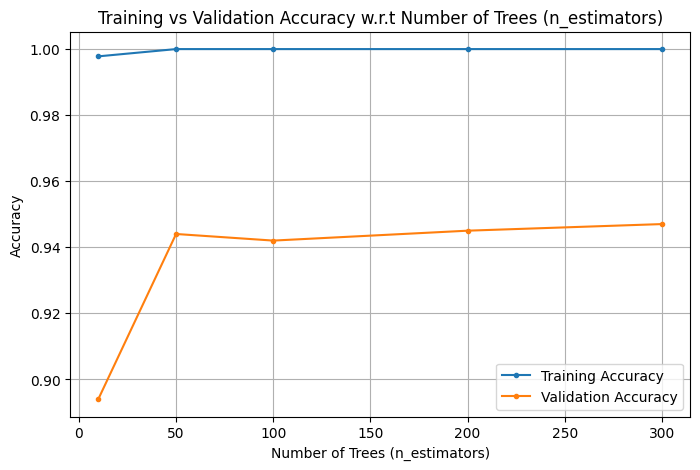

In [105]:
#3.2.2 line figure

# Extract values for plotting
n_estimators_values = randforest_n_estimators_results_df["n_estimators"]
train_acc_values = randforest_n_estimators_results_df["mean_training_accuracy"]
val_acc_values = randforest_n_estimators_results_df["mean_validation_accuracy"]

plt.figure(figsize=(8, 5))

# Plot training and validation accuracy
plt.plot(n_estimators_values, train_acc_values, marker='.', label="Training Accuracy")
plt.plot(n_estimators_values, val_acc_values, marker='.', label="Validation Accuracy")

# Labels and Title
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy w.r.t Number of Trees (n_estimators)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [106]:
# 3.3 Use 5-fold cross-validation to evaluate the performance w.r.t. the minimum number of samples required to be at a leaf node (min_samples_leaf)
# 3.3.1 table

# Define different values for min_samples_leaf
min_samples_leaf_values = [1, 5, 10, 20, 50]

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store results
randforest_min_samples_leaf_results = []

# Loop through different min_samples_leaf values
for min_leaf in min_samples_leaf_values:
    train_acc = []
    val_acc = []

    # Perform 5-fold cross-validation
    for train_index, val_index in kf.split(train_val_X):
        train_X, val_X = train_val_X[train_index, :], train_val_X[val_index, :]
        train_y, val_y = train_val_y.iloc[train_index].values, train_val_y.iloc[val_index].values

        # Train Random Forest with varying min_samples_leaf
        rf_model = RandomForestClassifier(min_samples_leaf=min_leaf, random_state=42)
        rf_model.fit(train_X, train_y)

        # Compute accuracy
        train_acc.append(rf_model.score(train_X, train_y))
        val_acc.append(rf_model.score(val_X, val_y))

    # Compute mean & std deviation
    mean_train_acc = np.mean(train_acc)
    std_train_acc = np.std(train_acc)
    mean_val_acc = np.mean(val_acc)
    std_val_acc = np.std(val_acc)

    # Store results
    randforest_min_samples_leaf_results.append({
        "min_samples_leaf": min_leaf,
        "mean_training_accuracy": round(mean_train_acc, 4),
        "std_training_accuracy": round(std_train_acc, 4),
        "mean_validation_accuracy": round(mean_val_acc, 4),
        "std_validation_accuracy": round(std_val_acc, 4),
    })

# Convert results to DataFrame
randforest_min_samples_leaf_results_df = pd.DataFrame(randforest_min_samples_leaf_results)

# Display table
randforest_min_samples_leaf_results_df

,min_samples_leaf,mean_training_accuracy,std_training_accuracy,mean_validation_accuracy,std_validation_accuracy
0,1,1.0000,0.0000,0.942,0.0129
1,5,0.9815,0.0035,0.945,0.0089
2,10,0.9620,0.0039,0.931,0.0132
3,20,0.9338,0.0061,0.903,0.0201
4,50,0.6768,0.0226,0.638,0.0273


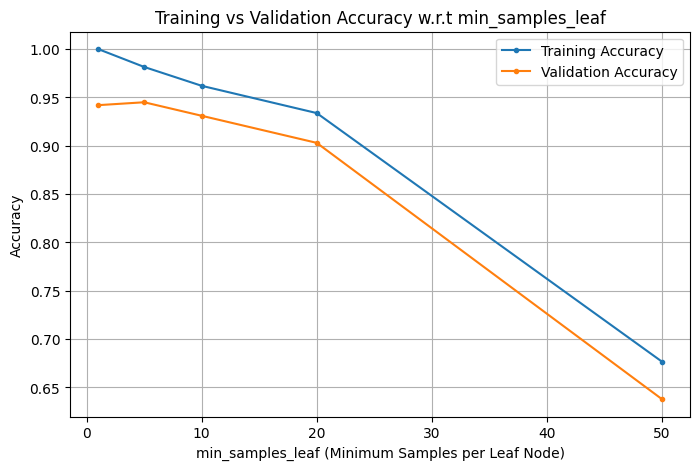

In [107]:
# 3.3.2 line figure

# Extract values for plotting
min_samples_leaf_values = randforest_min_samples_leaf_results_df["min_samples_leaf"]
train_acc_values = randforest_min_samples_leaf_results_df["mean_training_accuracy"]
val_acc_values = randforest_min_samples_leaf_results_df["mean_validation_accuracy"]

# Plot Training and Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(min_samples_leaf_values, train_acc_values, marker='.', label="Training Accuracy")
plt.plot(min_samples_leaf_values, val_acc_values, marker='.', label="Validation Accuracy")

# Labels and Title
plt.xlabel("min_samples_leaf (Minimum Samples per Leaf Node)")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy w.r.t min_samples_leaf")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

4.1 Describe how you pre-process the data to generate features.
1. Convert text into numbers using TF-IDF Vectorization (already done in Part 1).
2. Remove stopwords (common words like "the", "is", "and") that don’t add meaning.
3. Limit vocabulary size (max_features=5000) to prevent overfitting.


4.2 Describe how you choose the model and parameters.

From Part 2 and 3, we tested different models and parameters for:
- Decision Trees (part2)
 - min_samples_leaf (min_results_df) - 0.669~0.769%
 - max_features (max_results_df) - 0.584~0.769%
- Random Forests (part3)
 - n_estimators (randforest_n_estimators_results_df) - 0.894~0.947%
 - min_samples_leaf (randforest_min_samples_leaf_results_df) - 0.942~0.638%

performance based on mean_validation_accuracy



Final Model Choice:  
Since Random Forests model with 300 n_estimators parameter is best in validation accuracy of 0.947%, that is the model and parameter I use.

<!-- Since Boosting Trees performed best in validation accuracy, I use Gradient Boosting Trees (GradientBoostingClassifier) as the final model. -->

4.3 Describe the performance of your chosen model and parameter on the training data.

The Random Forest model with n_estimators = 300 shows perfect performance on the training data with:
- Mean Training Accuracy = 1.000 (100%)
Standard Deviation of Training Accuracy = 0.000 (No variation)
- This indicates that the model fully memorizes the training data, which is expected for Random Forests with a high number of estimators.

In [108]:
# 4 Predict the labels for the testing data (using raw training data and raw testing data).

article_ids = test_df['ArticleId']
# test_X = vectorizer.transform(test_df['Text']) already done above

# Initialize Random Forest model with n_estimators = 300
rf_model = RandomForestClassifier(n_estimators=300, random_state=42)

# Train the model on the training data
rf_model.fit(train_X, train_y)

# Predict the labels for the testing data
pred_y = rf_model.predict(test_X)

# Save predictions to labels.csv
labels_df = pd.DataFrame(list(zip(article_ids, pred_y)))
labels_df.to_csv("labels.csv", index=False, header=False)